# Strategy of Recommendation
* Import Dataset
Models:
* "baseline" —— simply recommend the 
*

Testing:
* Have letterboxd dataset of users, movies, and ratings
* Could threshold the ratings (assume a user will watch anything over a 7).
* Split "train" and "test"

# Importing Dataset

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


FOLDERNAME = 'cs229_proj/'


assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1FYI1gIgILgT31h2y_QMmBZOwkDqTPrg-/cs229_proj


In [ ]:
import numpy as np
from PIL import Image # for viewing images
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from collections import defaultdict

import torch
from torch.optim import lr_scheduler
import torch.nn as nn
from poster_dataset import PosterDataset
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
movies_full_path = '/content/drive/My Drive/cs229_proj/movies_full.csv'
user_ratings_full_path = '/content/drive/My Drive/cs229_proj/user_ratings_full.csv'
movies_embeddings_full_path = '/content/drive/My Drive/cs229_proj/movies_embeddings_full.csv'
movies_svd_path = '/content/drive/My Drive/cs229_proj/movies_svd_full.csv'

movies_full_df = pd.read_csv(movies_full_path)
ratings_full_df = pd.read_csv(user_ratings_full_path)
movies_embeddings_df = pd.read_csv(movies_embeddings_full_path)
movies_svd_df = pd.read_csv(movies_svd_path)

ratings_full_df

,user_id,movie_id,rating_val
0,shawn_stubbs,the-addams-family,9
1,ramiraff,the-truman-show,9
2,joshua_toomes,the-bourne-identity-2002,8
3,henryg9876,up,8
4,denny_crane,eight-legged-freaks,5
...,...,...,...
392546,jdoan,into-the-woods-2014,5
392547,jdoan,zero-dark-thirty,7
392548,jdoan,the-big-lebowski,9
392549,jdoan,aliens,8


In [ ]:
users_set = set(ratings_full_df['user_id'].to_list())

In [ ]:

def get_input_and_holdout(movieid_lst, user_rating_lst, frac=0.8):
    n = len(movieid_lst)
    n_holdout_goal = int((1 - frac) * n)
    avg_rating = np.mean(np.array(user_rating_lst))

    all_indices = [*range(n)]

    # print(n_holdout_goal, n)
    if n <= 20:
        # print("bruh")
        return None, None

    for i in range(1000):
        # sample potential holdout movies
        cur_indices = random.sample(all_indices, n_holdout_goal)

        # get potential holdout movies ratings
        holdout_ratings = np.array(user_rating_lst)[cur_indices]
       
        # such that the holdout movies approximately match the user's average ratings
        if abs(np.mean(holdout_ratings) - avg_rating) < 0.5:
            # print(len(holdout_ratings) / n, np.mean(holdout_ratings), avg_rating)
            input_dict = {}
            holdout_dict = {}
            for j in range(n):
                cur_movieid = movieid_lst[j]
                if j in cur_indices:
                    holdout_dict[cur_movieid] = user_rating_lst[j]
                else:
                    input_dict[cur_movieid] = user_rating_lst[j]
            # # print(i)
            return input_dict, holdout_dict
    return None, None
    # print(n, avg_rating, user_rating_lst)
    # raise Exception("You suck. 1000 iterations you IDIOT.")

In [ ]:

count = 0
dont_count = 0
# new_user_id = None
user_to_dicts = {}
for user_id in users_set:
    count += 1
    # if count == 1000: # something less than or equal to 5227
    #     new_user_id = user_id
    #     break
    # print(new_user_id)

    # get all of user's movie ratings
    user_df = ratings_full_df.loc[ratings_full_df['user_id'] == user_id]
    # print(user_df.shape)

    # get list of movies user rated
    user_movieid = user_df['movie_id'].to_list()

    # get list of ratings for said movies
    user_ratings = user_df['rating_val'].to_list()

    # get a list of movies which are 
    input_dict, holdout_dict = get_input_and_holdout(user_movieid, user_ratings)

    # if holdout is empty, iterate
    if input_dict is None:
        dont_count += 1
    else:
        user_to_dicts[user_id] = [input_dict, holdout_dict]
    if count % 100 == 0:
        print(count, dont_count)
    

100 14
200 28
300 41
400 57
500 76
600 91
700 107
800 124
900 134
1000 151
1100 170
1200 190
1300 206
1400 223
1500 240
1600 258
1700 269
1800 278
1900 293
2000 312
2100 324
2200 339
2300 353
2400 370
2500 385
2600 399
2700 414
2800 431
2900 446
3000 462
3100 477
3200 493
3300 506
3400 525
3500 538
3600 555
3700 573
3800 591
3900 608
4000 622
4100 634
4200 646
4300 666
4400 680
4500 696
4600 710
4700 728
4800 745
4900 766
5000 778
5100 793
5200 810


In [ ]:
print(user_to_dicts['reviewsbycaleb'][0])
print(user_to_dicts['reviewsbycaleb'][1])
keys1 = set(user_to_dicts['reviewsbycaleb'][0].keys())
keys2 = set(user_to_dicts['reviewsbycaleb'][1].keys())
assert(len(keys1.intersection(keys2)) == 0)

{'running-scared-2006': 6, 'lord-of-war': 7, 'mad-max-fury-road': 9, 'australia': 5, 'traffic': 6, '2012': 6, 'little-miss-sunshine': 4, 'rescue-dawn': 3, 'before-sunrise': 8, 'pearl-harbor': 7, 'back-to-the-future': 8, 'wall-street': 8, 'harry-potter-and-the-goblet-of-fire': 9, 'la-confidential': 10, 'the-kingdom-2007': 5, 'hugo': 9, 'dallas-buyers-club': 5, 'spaceballs': 8, 'the-chronicles-of-narnia-the-lion-the-witch-and-the-wardrobe': 3, 'this-means-war': 6, 'gone-girl': 6, 'boogie-nights': 7, 'the-imaginarium-of-doctor-parnassus': 6, 'adaptation': 9, 'once-upon-a-time-in-america': 4, 'the-descendants': 8, 'edge-of-tomorrow': 8, 'the-grand-budapest-hotel': 7, 'mission-impossible-ghost-protocol': 6, 'napoleon-dynamite': 8, 'hot-rod': 9, 'oldboy': 10, 'christmas-with-the-kranks': 4, 'harry-potter-and-the-half-blood-prince': 8, 'insidious-chapter-2': 4, 'cars-2': 4, 'baby-mama': 3, 'woman-in-gold': 5, 'spotlight': 10, 'signs': 7, 'groundhog-day': 7, 'the-last-samurai': 7, 'shrek': 7, 

# Baseline

In [ ]:
movieid_lst = list(movies_full_df['movie_id'].to_list())
boxd_avg_lst = list(movies_full_df['boxd_vote_average'].to_list())

In [ ]:
zipped_lists = zip(boxd_avg_lst, movieid_lst)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
boxd_avg_lst_sorted, movieid_lst_sorted = [ list(tuple) for tuple in  tuples]
boxd_avg_lst_sorted = list(reversed(boxd_avg_lst_sorted))
movieid_lst_sorted = list(reversed(movieid_lst_sorted))

In [ ]:
def get_recommendations_score(input_dict, holdout_dict, movieid_lst):
    recommendations = []
    holdout_ratings = np.array(list(holdout_dict.values()))
    holdout_ratings_chosen = []
    for movie_id in movieid_lst:
        if movie_id not in input_dict:
            if movie_id in holdout_dict:
                holdout_ratings_chosen.append(holdout_dict[movie_id])
            recommendations.append(movie_id)
            if len(recommendations) >= 100 and len(holdout_ratings_chosen) >= 4:
                break
    
    if len(holdout_ratings_chosen) == 0:
      score = 0
      print("no recommendations made for this user")
    else:
      holdout_avg = np.mean(holdout_ratings)
      holdout_ratings_chosen = np.array(holdout_ratings_chosen)
      score = np.mean(holdout_ratings_chosen) - holdout_avg
    return score, recommendations, len(holdout_ratings_chosen)

In [ ]:
scores = []
holdout_counts = []
recc_counts = []
for user in tqdm(user_to_dicts):
    input_dict, holdout_dict = user_to_dicts[user]
    score, reccs, holdout_count = get_recommendations_score(input_dict, holdout_dict, movieid_lst_sorted)
    scores.append(score)
    holdout_counts.append(holdout_count)
    recc_counts.append(len(reccs))
    # print(score)

scores = np.array(scores)

print(np.mean(scores))
print(np.mean(holdout_counts))
print(np.mean(recc_counts))

100%|██████████| 4417/4417 [00:00<00:00, 4824.77it/s]

1.1910181584506847
4.0864840389404575
434.6244057052298


# KNN 
aka another way of sorting than just top user ratings

In [ ]:
# design an embedding for each movie
def get_movie_embeddings():
  # let's start with the stupid one: just return the letterboxd histogram
  movie_embedding = np.array(movies_full_df[[str(i) for i in range(1, 11)]])
  
  # TODO: one-hot code genre, actors?
  # https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/
  # https://sparrow.dev/pytorch-one-hot-encoding/

  return torch.tensor(movie_embedding).float()

E = get_movie_embeddings()
print(E.shape)

torch.Size([2220, 10])


In [ ]:
# design a user embedding which weighted averages their movies based on what they like. 
# something like (E[movies] * weights).mean() where weights = (rating - 5)/10
def get_user_embedding(input_dict):
  embedding = torch.zeros(E.shape[1])
  avg_rating = np.mean(np.array(list(input_dict.values())))
  for movie, rating in input_dict.items():
    ind = movies_full_df.index[movies_full_df['movie_id'] == movie]
    if not len(ind):
      print(movie)
      continue
    else:
      ind = ind[0]
    embedding += (rating - avg_rating) / 10 * E[ind] 
  return embedding



In [ ]:
def get_recommendations(input_dict):
  # KNN operates on the average 
  liked_movies_embed = get_user_embedding(input_dict)

  dists = nn.CosineSimilarity()(liked_movies_embed, E)
  knn = dists.topk(2200, largest=True)
  return knn


In [ ]:
scores = []
holdout_counts = []
recc_counts = []

i = 0
for user in tqdm(user_to_dicts): 
  input_dict, holdout_dict = user_to_dicts[user]
  knn = get_recommendations(input_dict)
  movieid_lst_sorted = list(movies_full_df.iloc[knn.indices.tolist()]['movie_id'].to_list())
  # print(movieid_lst_sorted[:10])
  score, reccs, holdout_count = get_recommendations_score(input_dict, holdout_dict, movieid_lst_sorted)
  scores.append(score)
  holdout_counts.append(holdout_count)
  recc_counts.append(len(reccs))
  if user == 'jdoan':
    print(reccs)

scores = np.array(scores)

print(np.mean(scores))
print(np.mean(holdout_counts))
print(np.mean(recc_counts))

 42%|████▏     | 1874/4417 [01:00<01:26, 29.39it/s]

['the-silence-of-the-lambs', 'inglourious-basterds', 'princess-mononoke', 'howls-moving-castle', 'amadeus', 'the-thing', 'akira', 'a-separation', 'good-will-hunting', 'do-the-right-thing', 'saving-private-ryan', 'the-iron-giant', 'whiplash-2014', 'city-of-god', 'trainspotting', 'dancer-in-the-dark', 'prisoners', 'das-boot', 'the-green-mile', 'amelie', 'blade-runner', 'her', 'the-secret-in-their-eyes', 'malcolm-x-1992', 'interstellar', 'brokeback-mountain', 'there-will-be-blood', 'brazil', 'unforgiven', 'coraline', 'the-lives-of-others', 'the-white-ribbon', 'nine-queens', 'hot-fuzz', 'children-of-heaven', 'evil-dead-ii', 'the-shawshank-redemption', '4-months-3-weeks-and-2-days', 'the-great-beauty', 'the-celebration', 'casino', 'monsters-inc', 'pride-prejudice', 'persepolis', 'little-miss-sunshine', 'american-beauty', 'ed-wood', 'adaptation', 'hedwig-and-the-angry-inch', 'indiana-jones-and-the-last-crusade', 'spirited-away', 'central-station', 'american-history-x', 'room-2015', 'the-thin

100%|██████████| 4417/4417 [02:23<00:00, 30.76it/s]

1.1915805736723706
4.081503282771112
445.2796015395065


# SVD
https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/

In [ ]:
movies_full_df[movies_full_df['movie_id'] == 'inception']

,movie_id,poster_path,title,year,1,2,3,4,5,6,7,8,9,10,tmdb_budget,imdb_budget,tmdb_revenue,imdb_revenue,tmdb_vote_average,tmdb_vote_count,imdb_vote_average,imdb_vote_count,tmdb_popularity,tmdb_runtime,imdb_runtime,main_genre,genres,director,writer,main_actor,mpaa_rating,overview,tagline,keywords,release_date,main_prod_company,production_companies,country,production_countries,original_language,spoken_languages,rt_info,critics_consensus,actors,tm_status,tm_rating,tm_count,audience_status,audience_rating,audience_count,tm_top_critics_count,tm_fresh_critics_count,tm_rotten_critics_count,ebert_rating,boxd_vote_average
1,inception,1,Inception,2010,1250,3550,2063,13735,11410,71166,69034,232098,117643,245070,160000000.0,160000000.0,825532764.0,836836967.0,8.1,13752.0,8.8,2100000.0,167.58371,148.0,148.0,Action,"[""Action"", ""Thriller"", ""Science Fiction"", ""Mys...",Christopher Nolan,Christopher Nolan,Leonardo DiCaprio,PG-13,"Cobb, a skilled thief who commits corporate es...",Your mind is the scene of the crime.,"[""loss of lover"", ""dream"", ""kidnapping"", ""slee...",2010-07-14,Warner Bros.,"[""Legendary Pictures"", ""Warner Bros."", ""Syncopy""]",United States,"[""United Kingdom"", ""United States of America""]",en,"[""English"", ""\u65e5\u672c\u8a9e"", ""Fran\u00e7a...",Dom Cobb (Leonardo DiCaprio) is a thief with t...,"Smart, innovative, and thrilling, Inception is...","Leonardo DiCaprio, Ken Watanabe, Joseph Gordon...",Certified-Fresh,87.0,357.0,Upright,91.0,571078.0,65.0,310.0,47.0,4.0,8.347947


In [ ]:
# create user-movie affinity matrix
# convert each user and movie to an index
# not vectorized. sorry
users_list = list(set(ratings_full_df['user_id'].to_list()))
user_to_ind = {user_id : i for i, user_id in enumerate(users_list)}
movie_list = list(set(ratings_full_df['movie_id'].to_list()))
movie_id_to_ind = {movie_id : i for i, movie_id in enumerate(movie_list)}

ratings_mat = np.zeros(
    shape = (len(user_to_ind),len(movie_id_to_ind)))

for i, movie_id in tqdm(enumerate(movie_list)):
    ratings_mat[:, i] += float(movies_full_df[movies_full_df['movie_id'] == movie_id]['boxd_vote_average'])

for index, row in tqdm(ratings_full_df.iterrows()):
    ratings_mat[user_to_ind[row['user_id']], movie_id_to_ind[row['movie_id']]] = row['rating_val']


# for index, row in tqdm(ratings_full_df.iterrows()):
#     rec = 1 if row['rating_val'] >= 6 else 0
#     ratings_mat[user_to_ind[row['user_id']], movie_id_to_ind[row['movie_id']]] = rec
  




2220it [00:02, 1010.60it/s]
392551it [00:51, 7653.33it/s]


In [ ]:
print(ratings_mat.shape)
ratings_mat

(5227, 2220)


array([[6.98415493, 6.59958205, 5.38530302, ..., 6.61188908, 7.04917449,
        5.84376341],
       [6.98415493, 6.59958205, 5.38530302, ..., 6.61188908, 7.04917449,
        5.84376341],
       [6.98415493, 6.59958205, 5.38530302, ..., 6.61188908, 7.04917449,
        5.84376341],
       ...,
       [6.98415493, 6.59958205, 5.38530302, ..., 6.61188908, 7.04917449,
        5.84376341],
       [8.        , 6.59958205, 5.38530302, ..., 6.61188908, 7.04917449,
        5.84376341],
       [6.98415493, 6.59958205, 5.38530302, ..., 6.61188908, 7.04917449,
        5.84376341]])

In [ ]:
U, S, V = np.linalg.svd(ratings_mat)
# U should represent the matrix of user embeddings,
# V.T the matrix of movie embeddings

0.7268184316848624
(5227, 5227) (2220, 2220)


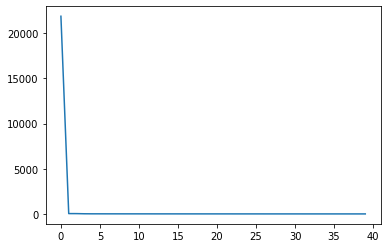

In [ ]:
plt.plot(range(40), [S[i] for i in range(40)])
print(sum(S[:750]) / sum(S)) # 60% of variation!
print(U.shape, V.shape)

U_reduced = U[:, :750]
V_reduced = V[:750, :]

In [ ]:
# test for jesse's account
user = 'jdoan'
dists = nn.CosineSimilarity()(torch.tensor(U_reduced[user_to_ind[user]]), torch.tensor(V_reduced.T))
knn = dists.topk(2000, largest=True)
movieid_lst_sorted = [movie_list[i] for i in knn.indices]
movieid_lst_sorted[:100]

['the-ghost-writer',
 'a-serious-man',
 'the-hunt-2012',
 'burn-after-reading',
 'collateral',
 'being-john-malkovich',
 'american-psycho',
 'die-hard',
 'anomalisa',
 'drag-me-to-hell',
 'sin-city',
 'the-incredibles',
 'memento',
 'black-swan',
 'back-to-the-future',
 'schindlers-list',
 'boogie-nights',
 'pans-labyrinth',
 'requiem-for-a-dream',
 'the-lord-of-the-rings-the-return-of-the-king',
 'the-best-offer',
 'road-trip',
 'enter-the-void',
 'the-worlds-end',
 'the-social-network',
 'the-lord-of-the-rings-the-fellowship-of-the-ring',
 'the-lord-of-the-rings-the-two-towers',
 'the-ladykillers-2004-6',
 'on-flux-2005',
 'et-the-extra-terrestrial',
 'once-upon-a-time-in-america',
 'eternal-sunshine-of-the-spotless-mind',
 'charlie-wilsons-war',
 'the-thing',
 'speed',
 'the-diving-bell-and-the-butterfly',
 'we-were-soldiers',
 'horrible-bosses-2',
 'oldboy',
 'sex-and-the-city-2',
 'pan-2015',
 'wimbledon',
 'team-america-world-police',
 'there-will-be-blood',
 'no-country-for-old-

In [ ]:
scores = []
holdout_counts = []
recc_counts = []
for user in tqdm(user_to_dicts):
    input_dict, holdout_dict = user_to_dicts[user]
    dists = nn.CosineSimilarity()(torch.tensor(U_reduced[user_to_ind[user]]), torch.tensor(V_reduced.T))
    knn = dists.topk(2000, largest=True)
    movieid_lst_sorted = [movie_list[i] for i in knn.indices]
    score, reccs, holdout_count = get_recommendations_score(input_dict, holdout_dict, movieid_lst_sorted)
    scores.append(score)
    holdout_counts.append(holdout_count)
    recc_counts.append(len(reccs))
    # print(score)

scores = np.array(scores)

print(np.mean(scores))
print(np.mean(holdout_counts))
print(np.mean(recc_counts))

  2%|▏         | 100/4417 [00:02<01:52, 38.46it/s]

no recommendations made for this user


  6%|▋         | 280/4417 [00:07<01:49, 37.86it/s]

no recommendations made for this user


  8%|▊         | 362/4417 [00:09<01:45, 38.59it/s]

no recommendations made for this user


 11%|█         | 466/4417 [00:12<01:42, 38.45it/s]

no recommendations made for this user


 16%|█▌        | 706/4417 [00:18<01:40, 36.89it/s]

no recommendations made for this user


 16%|█▋        | 718/4417 [00:19<01:37, 37.88it/s]

no recommendations made for this user


 28%|██▊       | 1236/4417 [00:33<01:23, 38.04it/s]

no recommendations made for this user


 34%|███▍      | 1512/4417 [00:40<01:16, 38.00it/s]

no recommendations made for this user


 38%|███▊      | 1697/4417 [00:45<01:09, 39.14it/s]

no recommendations made for this user


 41%|████      | 1821/4417 [00:48<01:13, 35.34it/s]

no recommendations made for this user


 44%|████▍     | 1963/4417 [00:52<01:03, 38.61it/s]

no recommendations made for this user


 54%|█████▍    | 2395/4417 [01:04<00:52, 38.58it/s]

no recommendations made for this user


 54%|█████▍    | 2403/4417 [01:04<00:52, 38.20it/s]

no recommendations made for this user


 55%|█████▍    | 2415/4417 [01:04<00:53, 37.74it/s]

no recommendations made for this user


 61%|██████    | 2679/4417 [01:11<00:45, 38.58it/s]

no recommendations made for this user


 61%|██████▏   | 2707/4417 [01:12<00:45, 37.56it/s]

no recommendations made for this user


 69%|██████▊   | 3032/4417 [01:21<00:37, 37.15it/s]

no recommendations made for this user


 71%|███████   | 3132/4417 [01:23<00:35, 36.68it/s]

no recommendations made for this user
no recommendations made for this user


 77%|███████▋  | 3388/4417 [01:30<00:27, 37.91it/s]

no recommendations made for this user


 84%|████████▍ | 3705/4417 [01:39<00:19, 37.12it/s]

no recommendations made for this user


 85%|████████▍ | 3735/4417 [01:40<00:17, 38.90it/s]

no recommendations made for this user


 89%|████████▉ | 3952/4417 [01:45<00:12, 38.70it/s]

no recommendations made for this user


 92%|█████████▏| 4085/4417 [01:49<00:09, 35.62it/s]

no recommendations made for this user


 94%|█████████▍| 4162/4417 [01:51<00:06, 37.09it/s]

no recommendations made for this user


100%|██████████| 4417/4417 [01:58<00:00, 37.41it/s]

1.443118018633193
6.621236133122029
537.7602445098483


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 1.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619420 sha256=444a4bd7a8386d1689155d2bb930fd964d35f0c955e89796b031f477bce0e335
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split


# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k')

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)


RMSE: 0.9376


0.9376095390019544